<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/In-Class_Problems/problems_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction to PyTorch: Automatic Differentiation**

In [1]:
import numpy as np
import torch
import sklearn.datasets
import matplotlib.pyplot as plt
from IPython.display import clear_output
#%matplotlib inline

In [23]:
# Create tensors
a = torch.tensor(5, dtype = torch.long)
b = torch.tensor(5, dtype = torch.int32)
b.dtype

torch.int32

Comparison with numpy:
https://github.com/torch/torch7/wiki/Torch-for-Numpy-users

In [24]:
c = torch.ones(6)
print(c, c.dtype)

tensor([1., 1., 1., 1., 1., 1.]) torch.float32


In [25]:
# Shape
c.size() #equivalent to x.shape in NumPy

torch.Size([6])

In [26]:
# Broadcasting
d = c + 1
print(d)

tensor([2., 2., 2., 2., 2., 2.])


In [27]:
# Change type
b.float() #b.to(torch.float)
b.dtype
# ".to puts everything on the GPU"

torch.int32

In [28]:
# Reshape tensors
c.view(2,3)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [29]:
c.size()

torch.Size([6])

In [30]:
# Squeeze/Unsqueeze   notice that we've added another dimension to tensor c
c.unsqueeze(dim=0).shape

torch.Size([1, 6])

In [31]:
# c.unsqueeze(dim=1).shape

In [32]:
# c.unsqueeze(dim=1)

In [33]:
# Dot product VS matrix multiplication

In [34]:
d.dot(c) #torch.matmul(d.T,c)

tensor(12.)

###In-place operations

The memory must be used efficiently when working with large tensors. Some operations create new object as the result of computations, others just change given object (in-place operations). In pytorch, these operations usually differ by adding an underscore:

`x.exp()   # not-in-place operation`

`x.exp_()  # in-place operation`



## Automatic Differentiation
tensor.data, tensor.grad, tensor.grad_fn
## Detaching variables

`.detach()` returns a copy of a variable, through which backpropagation doesn't pass. If you average or just store batch losses during the optimization, you'd better detach those losses before averaging or storing. Otherwise the computational graphs for each batch would be stored in memory as well as batch losses, so you run out of memory very fast.

Also there is in-place version (`.detach_()`) which doesn't create detached copy of the variable, but detach variable itself from its computational graph.

In [62]:
a = torch.rand(1, requires_grad=True) # When we pass 'a' into a function, its children will also require a gradient
b = torch.sin(a)

In [63]:
a

tensor([0.3532], requires_grad=True)

In [64]:
b

tensor([0.3459], grad_fn=<SinBackward0>)

Use method tensor.backward() for b and print the derivative of b with respect to a (a.grad).

In [65]:
b.backward() # runs the back propogation
print(a.grad, torch.cos(a.data)) # the derivative of sine is cosine

# "The gradient of sine is cosine"

tensor([0.9383]) tensor([0.9383])


In [66]:
x = torch.randn(4, requires_grad=True) # create a random tensor of 4 values
y0 = torch.randn(4, requires_grad=True) # create a random tensor of 4 values
y = y0.detach() # we detached the gradient from y
z = x * y + 10
p = z.sum()
p.backward()
print('x:', x.data)
print('y:', y.data)
print('dp / dx:', x.grad)
print('dp / dy:', y.grad)

x: tensor([-1.4455,  1.4874, -1.1895, -0.9691])
y: tensor([ 0.2851,  0.0745,  0.3443, -1.6782])
dp / dx: tensor([ 0.2851,  0.0745,  0.3443, -1.6782])
dp / dy: None


##Gradient reset

In [67]:
x = torch.tensor([1, 1, 1, 1.], requires_grad=True)
y = x ** 2
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)
x.grad.detach_()       # extracting gradient Variable from the previous computational graph (optional)
x.grad.zero_()         # zero gradinents
y = 1 / x
p = y.sum()
p.backward()
print('x:', x)
print('dp / dx:', x.grad)

x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([2., 2., 2., 2.])
x: tensor([1., 1., 1., 1.], requires_grad=True)
dp / dx: tensor([-1., -1., -1., -1.])


##Leaf vs Non-leaf Variable

In [68]:
x = torch.randn(4, requires_grad=True)  # leaf variable
y = x + 1                               # not a leaf variable
p = y.sum()                             # not a leaf variable
p.backward()
print('x:', x)
print('y:', y)
print('p:', p)
print('x.grad:', x.grad)
print('y.grad:', y.grad)
print('p.grad:', p.grad)

x: tensor([-1.4784,  1.7884, -0.0775, -0.7023], requires_grad=True)
y: tensor([-0.4784,  2.7884,  0.9225,  0.2977], grad_fn=<AddBackward0>)
p: tensor(3.5302, grad_fn=<SumBackward0>)
x.grad: tensor([1., 1., 1., 1.])
y.grad: None
p.grad: None


<ipython-input-68-9cd951bbac27>:9: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print('y.grad:', y.grad)
<ipython-input-68-9cd951bbac27>:10: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pyto

##Gradients for non-leaf variables

In [69]:
x = torch.randn(4, requires_grad=True)   # leaf variable
z = torch.randn(4, requires_grad=True)   # leaf variable
w = z * 2      # not a leaf variable
y = x * w + 1  # forward pass before retaining gradient is ok
p = y.sum()

w.retain_grad() # we get w from doing z*2, so it's kind of the beginnings of the gradient of MSE

p.backward()
print('dp / dx:', x.grad)
print('dp / dz:', z.grad)
print('dp / dw:', w.grad)

dp / dx: tensor([-0.9167,  1.8454,  0.4926, -0.6543])
dp / dz: tensor([ 2.4942,  1.2246, -0.4684,  1.2643])
dp / dw: tensor([ 1.2471,  0.6123, -0.2342,  0.6322])


## In this section, we use atomatic differentiation for the Gradient Descend

In [70]:
torch.manual_seed(0)
x = torch.linspace(1, 5, 20)
y = 2*x + 1 + 5*torch.rand(len(x))

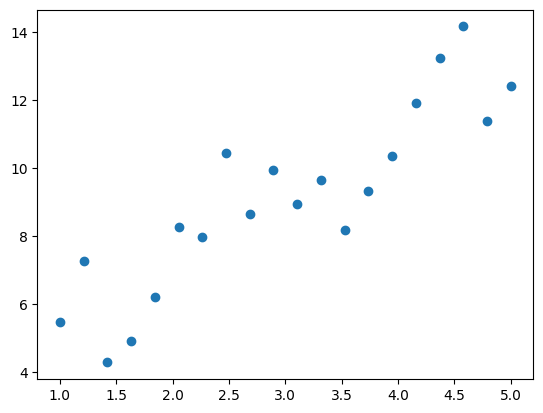

In [71]:
plt.scatter(x,y)

### Q1 (1 pt).   Initialize the weights and bais with gradients (see example with `sin(a)`).

In [72]:
# w = #your code
w = torch.tensor(1., requires_grad=True)
# b = #your code
b = torch.tensor(1., requires_grad=True)

In [73]:
w, b

(tensor(1., requires_grad=True), tensor(1., requires_grad=True))

### Q2 (2pt). Write the gradient descent using automated calculation of the gradients of `w` and `b`.

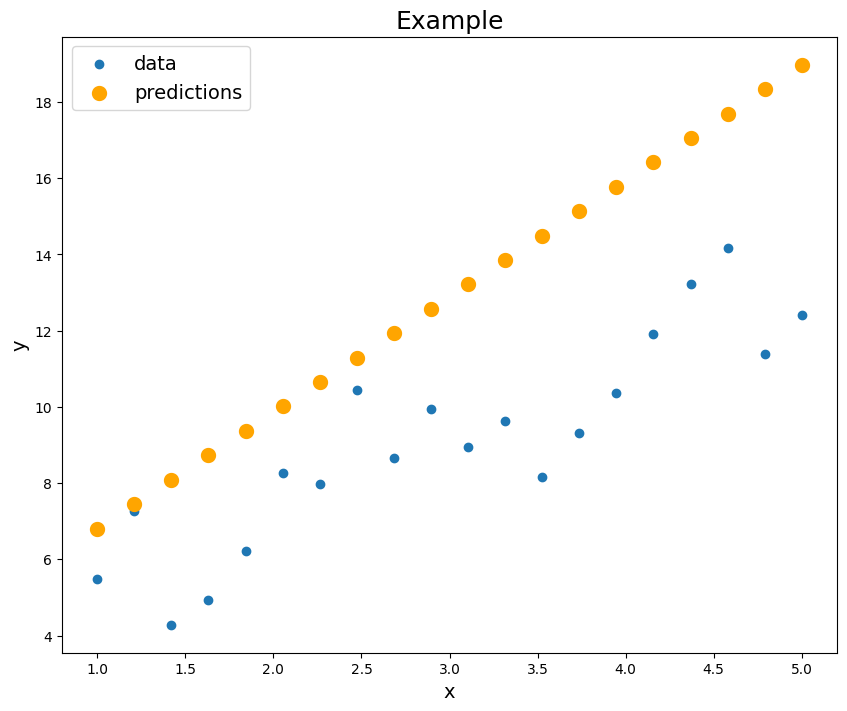

In [74]:
alpha = 0.001 #learning rate
for i in range(100):   #number of epochs
  #if the gradients are non empty, zero them:

  # calculate prediction y_p = w*x+b:
  y_p = w*x + b

  # calculate loss mean((y_p-y)**2):
  loss = ((y_p - y)**2).mean()

  # run loss.backward() to calculate the derivatives
  loss.backward()

  # update the values of w and b, using learning rate alpha and gradients
  w.data = w.data - alpha * w.grad.data
  b.data = b.data - alpha * b.grad.data

  #visualisation:
  if (i + 1) % 5 == 0:
    clear_output(True)
    plt.figure(figsize=(10,8))
    plt.scatter(x, y, label="data")
    plt.scatter(x, y_p.data.numpy(), color="orange", linewidth=5, label="predictions")
    plt.xlabel("x", fontsize=14)
    plt.ylabel("y", fontsize=14)
    plt.title("Example", fontsize=18)
    plt.legend(fontsize=14)
    plt.show()